experimenting with pretrained model

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import os
from keras.applications import ResNet50



# Paths to training and testing data
training_data_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/preTrainedModel/data/10folds - 70-15-15 train test split (includes all subjects)/fold1/Training'
testing_data_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/preTrainedModel/data/10folds - 70-15-15 train test split (includes all subjects)/fold1/Testing'

# Image dimensions
img_height, img_width = 224, 224

# Define batch size
batch_size = 32

# Create data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # bc we have two classes
)

# # Print the class names
# class_names = list(train_generator.class_indices.keys())
# print("Class Names:", class_names)

test_generator = test_datagen.flow_from_directory(
    testing_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained ResNet-50 model with weights from ImageNet
base_model = ResNet50(
    include_top=False, # don't want to include the top layer because we will define our own input/output layer
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    # pooling=None,
    pooling= 'max',
    classes=2,
)
# Freeze the layers of the pre-trained model
# for layer in base_model.layers:
#     layer.trainable = False
for layer in base_model.layers[:-4]:
    layer.trainable = True

# base_model.trainable = False
    
# Add custom classification layers on top of ResNet-50
# these new layers and specifically the 512 neurons are the ones that will be learning the new weights 
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)  # Assuming 2 classes: Healthy and Hearing Impaired


# Create the final model
model = keras.Model(base_model.input, x)

# Print model summary
model.summary()

# # Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(train_generator, epochs=10, validation_data=test_generator)
history = model.fit(train_generator, epochs=10)

# # Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Save accuracies during training
train_accuracies = history.history['accuracy']

# Evaluate the model on the testing data and get predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Calculate precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Save metrics to a text file
with open('classification_results.txt', 'w') as file:
    file.write(f'Test Accuracy: {test_acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1 Score: {f1_score}\n')

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

Found 1440 images belonging to 2 classes.


Found 320 images belonging to 2 classes.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                   

/home/wangg/miniconda3/envs/REU-Hearing-Loss-Project/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-01-23 17:03:25.825998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 384s 8s/step - loss: 7.0894 - accuracy: 0.5201
Epoch 2/10
45/45 [==============================] - 389s 9s/step - loss: 1.1145 - accuracy: 0.5208
Epoch 3/10
45/45 [==============================] - 626s 14s/step - loss: 0.6808 - accuracy: 0.5799
Epoch 4/10
45/45 [==============================] - 607s 14s/step - loss: 0.6346 - accuracy: 0.6347
Epoch 5/10
45/45 [==============================] - 598s 13s/step - loss: 0.6075 - accuracy: 0.6653
Epoch 6/10
45/45 [==============================] - 600s 13s/step - loss: 0.5536 - accuracy: 0.7188
Epoch 7/10
45/45 [==============================] - 609s 14s/step - loss: 0.4964 - accuracy: 0.7507
Epoch 8/10
45/45 [==============================] - 637s 14s/step - loss: 0.4540 - accuracy: 0.7861
Epoch 9/10
45/45 [==============================] - 781s 17s/step - loss: 0.3580 - accuracy: 0.8299
Epoch 10/10
45/45 [==============================] - 811s 18s/step - loss: 0.3012 - accuracy: 0.8653


2024-01-23 18:46:53.163403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 25s 2s/step - loss: 0.6931 - accuracy: 0.5000
Test Accuracy: 0.5


2024-01-23 18:47:38.560774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 28s 2s/step
Confusion Matrix:
[[  0 160]
 [  0 160]]


/home/wangg/miniconda3/envs/REU-Hearing-Loss-Project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Freezing all layers except last 4, 60 epochs, data augmentation with shuffle on 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import os
from keras.applications import ResNet50


# Paths to training and testing data
training_data_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/preTrainedModel/data/10folds - 70-15-15 train test split (includes all subjects)/fold1/Training'
testing_data_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/preTrainedModel/data/10folds - 70-15-15 train test split (includes all subjects)/fold1/Testing'

# Image dimensions
img_height, img_width = 224, 224

# Define batch size
batch_size = 32

# Create data generators for training and testing

# Create data generators for training and testing with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # bc we have two classes
    shuffle=True  # Ensure data is shuffled

)


# # Print the class names
# class_names = list(train_generator.class_indices.keys())
# print("Class Names:", class_names)

test_generator = test_datagen.flow_from_directory(
    testing_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained ResNet-50 model with weights from ImageNet
base_model = ResNet50(
    include_top=False, # don't want to include the top layer because we will define our own input/output layer
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    # pooling=None,
    pooling= 'max',
    classes=2,
)
# Freeze the layers of the pre-trained model
# for layer in base_model.layers:
#     layer.trainable = False
for layer in base_model.layers[:-4]:
    layer.trainable = True

# base_model.trainable = False
    
# Add custom classification layers on top of ResNet-50
# these new layers and specifically the 512 neurons are the ones that will be learning the new weights 
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)  # Assuming 2 classes: Healthy and Hearing Impaired


# Create the final model
model = keras.Model(base_model.input, x)

# Print model summary
model.summary()

from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    return lr * 0.1  # Adjust the factor as needed

lr_callback = LearningRateScheduler(lr_scheduler)

# # Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=45)

# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Save accuracies during training
train_accuracies = history.history['accuracy']

# Evaluate the model on the testing data and get predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Calculate precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Save classification results to a file
results_filename = 'classification_results_pretrained_model.txt'
with open(results_filename, 'w') as results_file:
    results_file.write("Image Name\tTrue Label\tPredicted Label\n")
    for i in range(len(test_generator.filenames)):
        image_name = os.path.basename(test_generator.filenames[i])
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save metrics to a text file
with open('classification_metrics_pretrained_model.txt', 'w') as file:
    file.write(f'Test Accuracy: {test_acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1 Score: {f1_score}\n')

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

2024-01-25 10:00:08.093748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1440 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


2024-01-25 10:00:09.614954: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/home/wangg/miniconda3/envs/REU-Hearing-Loss-Project/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/45


2024-01-25 10:00:11.788483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 611s 13s/step - loss: 7.1922 - accuracy: 0.4944
Epoch 2/45
45/45 [==============================] - 598s 13s/step - loss: 1.7702 - accuracy: 0.5049
Epoch 3/45
45/45 [==============================] - 602s 13s/step - loss: 1.2968 - accuracy: 0.5014
Epoch 4/45
45/45 [==============================] - 600s 13s/step - loss: 0.9801 - accuracy: 0.5000
Epoch 5/45
45/45 [==============================] - 602s 13s/step - loss: 0.8366 - accuracy: 0.4889
Epoch 6/45
45/45 [==============================] - 604s 13s/step - loss: 0.7920 - accuracy: 0.4993
Epoch 7/45
45/45 [==============================] - 573s 13s/step - loss: 0.6996 - accuracy: 0.4938
Epoch 8/45
45/45 [==============================] - 593s 13s/step - loss: 0.6955 - accuracy: 0.4896
Epoch 9/45
45/45 [==============================] - 621s 14s/step - loss: 0.6926 - accuracy: 0.5014
Epoch 10/45
45/45 [==============================] - 586s 13s/step - loss: 0.6945 - accuracy: 0.4938
Epoch 11/4

2024-01-25 18:14:47.897541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 22s 2s/step - loss: 0.8508 - accuracy: 0.4969
Test Accuracy: 0.49687498807907104


2024-01-25 18:15:10.708806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 23s 2s/step
Confusion Matrix:
[[  4 156]
 [  3 157]]


: 

In [8]:
# Evaluate the model on the testing data with a specific number of steps (epochs)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Save accuracies during training
train_accuracies = history.history['accuracy']
print (train_accuracies)

# Evaluate the model on the testing data and get predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes
print(true_labels)
# Calculate precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Save metrics to a text file
with open('classification_results.txt', 'w') as file:
    file.write(f'Test Accuracy: {test_acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1 Score: {f1_score}\n')


2024-01-24 12:50:34.548074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 17s 2s/step - loss: 0.8256 - accuracy: 0.5000
Test Accuracy: 0.5
Test Loss: 0.8255947232246399
[0.550694465637207, 0.5638889074325562, 0.6118055582046509, 0.6201388835906982, 0.6604166626930237, 0.6534722447395325, 0.6951388716697693, 0.7027778029441833, 0.7041666507720947, 0.7250000238418579, 0.7361111044883728, 0.7347221970558167, 0.7541666626930237, 0.7708333134651184, 0.7729166746139526]


2024-01-24 12:50:55.617897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 17s 2s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/wangg/miniconda3/envs/REU-Hearing-Loss-Project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing with tmux, 100 epochs

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import os
from keras.applications import ResNet50


# Paths to training and testing data
training_data_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/preTrainedModel/data/10folds - 70-15-15 train test split (includes all subjects)/fold1/Training'
testing_data_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/preTrainedModel/data/10folds - 70-15-15 train test split (includes all subjects)/fold1/Testing'

# Image dimensions
img_height, img_width = 224, 224

# Define batch size
batch_size = 32

# Create data generators for training and testing

# Create data generators for training and testing with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # bc we have two classes
    shuffle=True  # Ensure data is shuffled

)


# # Print the class names
# class_names = list(train_generator.class_indices.keys())
# print("Class Names:", class_names)

test_generator = test_datagen.flow_from_directory(
    testing_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained ResNet-50 model with weights from ImageNet
base_model = ResNet50(
    include_top=False, # don't want to include the top layer because we will define our own input/output layer
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    # pooling=None,
    pooling= 'max',
    classes=2,
)
# Freeze the layers of the pre-trained model
# for layer in base_model.layers:
#     layer.trainable = False


# for layer in base_model.layers[:-4]:
#     layer.trainable = True

# base_model.trainable = False
    
# Add custom classification layers on top of ResNet-50
# these new layers and specifically the 512 neurons are the ones that will be learning the new weights 
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)  # Assuming 2 classes: Healthy and Hearing Impaired


# Create the final model
model = keras.Model(base_model.input, x)

# Print model summary
model.summary()

from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    return lr * 0.1  # Adjust the factor as needed

lr_callback = LearningRateScheduler(lr_scheduler)

# # Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=100)

# Print the contents of history.history
print(history.history)
# Save training loss values
train_loss = history.history['loss']
train_accuracies = history.history['accuracy']

# Save training and test loss values to a file
losses_filename = 'losses_pretrained_model.txt'
with open(losses_filename, 'w') as losses_file:
    losses_file.write("Epoch\tTraining Loss\tTraining Accuracy\n")
    for epoch in range(len(train_loss)):
        losses_file.write(f"{epoch + 1}\t{train_loss[epoch]}\t{train_accuracies[epoch]}\n")


# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Save accuracies during training
train_accuracies = history.history['accuracy']

# Evaluate the model on the testing data and get predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Calculate precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Save classification results to a file
results_filename = 'classification_results_pretrained_model.txt'
with open(results_filename, 'w') as results_file:
    results_file.write("Image Name\tTrue Label\tPredicted Label\n")
    for i in range(len(test_generator.filenames)):
        image_name = os.path.basename(test_generator.filenames[i])
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save metrics to a text file
with open('classification_metrics_pretrained_model.txt', 'w') as file:
    file.write(f'Test Accuracy: {test_acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1 Score: {f1_score}\n')

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)


Found 1440 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

/home/wangg/miniconda3/envs/REU-Hearing-Loss-Project/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-01-25 19:56:53.434921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 72s 1s/step - loss: 1.6081 - accuracy: 0.4944
{'loss': [1.6080759763717651], 'accuracy': [0.49444442987442017]}


2024-01-25 19:58:06.261185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 16s 1s/step - loss: 0.7015 - accuracy: 0.5312
Test Accuracy: 0.53125


2024-01-25 19:58:22.446822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 16s 1s/step
Confusion Matrix:
[[151   9]
 [153   7]]


Plots for all folds (5 folds in this case)

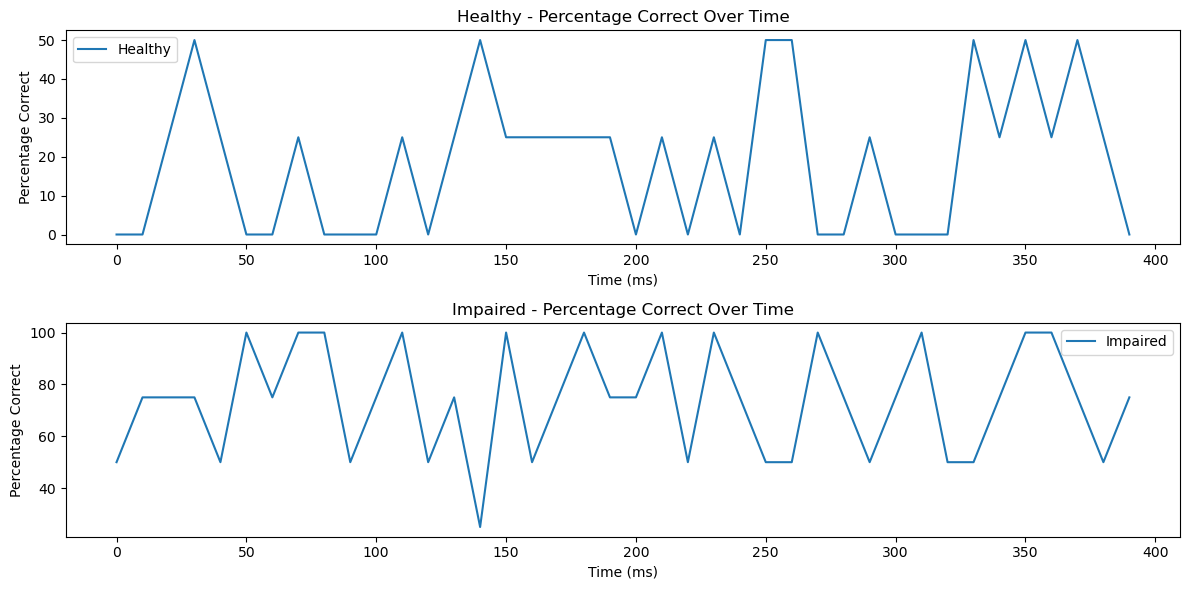

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'Time': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390],
    'Healthy': [0,0,25,50,25,0,0,25,0,0,0,25,0,25,50,25,25,25,25,25,0,25,0,25,0,50,50,0,0,25,0,0,0,50,25,50,25,50,25,0],
    'Impaired': [50,75,75,75,50,100,75,100,100,50,75,100,50,75,25,100,50,75,100,75,75,100,50,100,75,50,50,100,75,50,75,100,50,50,75,100,100,75,50,75]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Healthy
plt.subplot(2, 1, 1)
plt.plot(df['Time'], df['Healthy'], label='Healthy')

plt.xlabel('Time (ms)')
plt.ylabel('Percentage Correct')
plt.title('Healthy - Percentage Correct Over Time')
plt.legend()

# Plot for Impaired
plt.subplot(2, 1, 2)
plt.plot(df['Time'], df['Impaired'], label='Impaired')

plt.xlabel('Time (ms)')
plt.ylabel('Percentage Correct')
plt.title('Impaired - Percentage Correct Over Time')
plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
calculate accuracy given classification results for each fold

In [8]:
def calculate_accuracy(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    correct_predictions = 0
    total_predictions = 0

    for line in lines[1:]:  # Skip the header line
        parts = line.strip().split('\t')
        true_label = int(parts[1])
        predicted_label = int(parts[2])

        if true_label == predicted_label:
            correct_predictions += 1

        total_predictions += 1

    accuracy = correct_predictions / total_predictions * 100
    return accuracy

# Replace 'your_file_path.txt' with the actual path to your text file
file_path = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/finalPush/10Fold/results/10fold_classification_resultsDataAugment100epochs_fold_4.txt'
accuracy = calculate_accuracy(file_path)

print(f'Accuracy: {accuracy:.2f}%')



Accuracy: 54.69%


: 